In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Hand cleansed
Hand cleaned to removed duplicates

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [3]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

Idea:

* Sort portfolios on an annual baisis
* cacluated $\sigma$, $\mu$, skew, max drawdown

* Need to creat panel data and start running regression on that.  

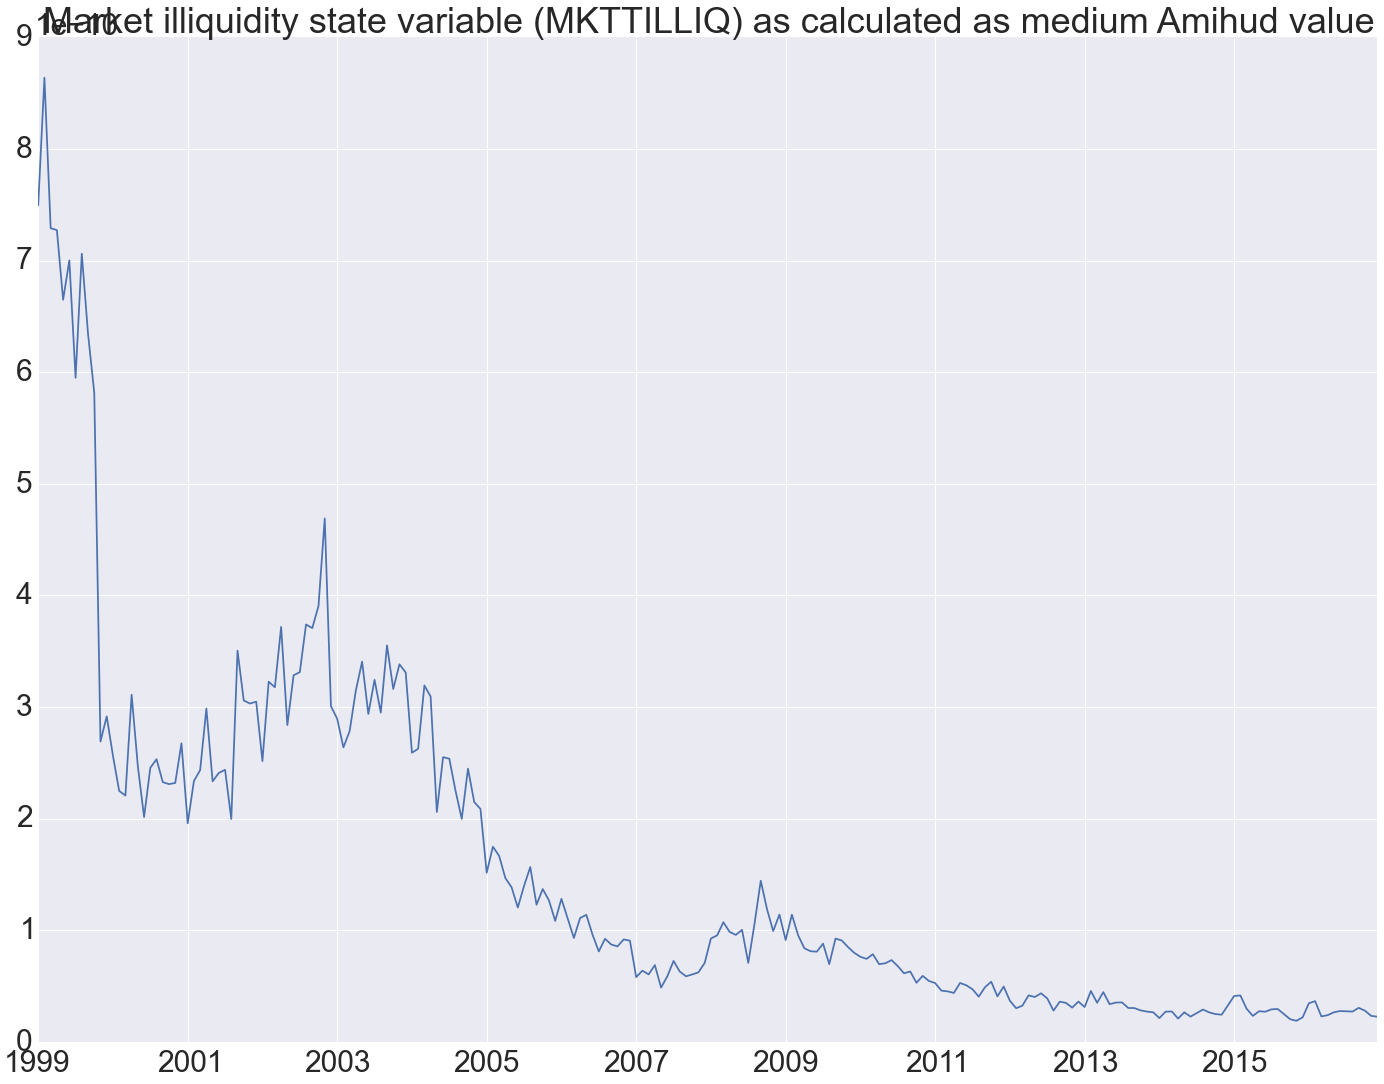

In [5]:
amihud.median(axis=1).dropna().plot(title='Market illiquidity state variable (MKTTILLIQ) as calculated as medium Amihud value')

# Further undersanding liquidity factor?

The further paper is trying to understand why do less liquid markets create this factor.  

Here are some ideas:
* Do some of the other state variables explain when illiquidity is profitable?  That's a bit weak, isn't it?  But if it is not you can run it on the IML, portfolio 1 and portfolio 10.  Something to ask new advisor.
* 

The other state variables:
* Amihud (MKTILLIQ)
* LIBOR
* Fed Funds
* TED
* Financial Stress
* NBER Recessions








#  Potential state and control variables 

I think there are lots of possibilities:
* Amihud (MKTILLIQ)
* LIBOR
* Fed Funds
* TED
* Financial Stress
* NBER Recessions

For table 1 we should run correlation matrix on monthly data to see if these are explaining the same thing.  

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


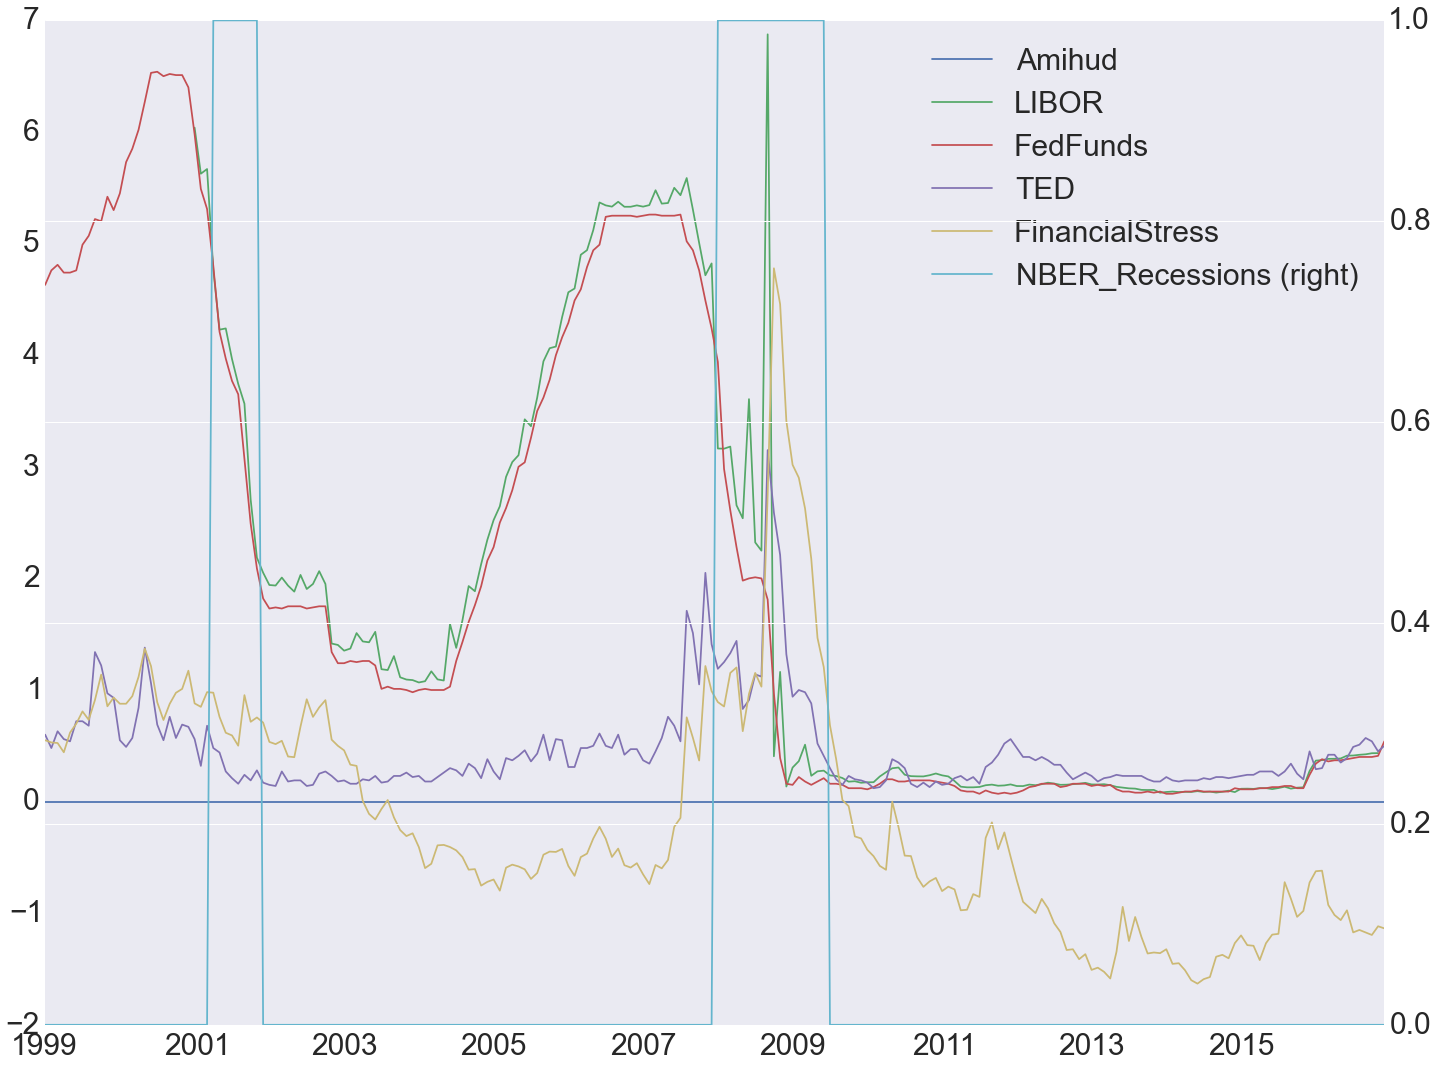

In [47]:
df=pd.DataFrame()
df['Amihud']=amihud.median(axis=1).dropna()
df['LIBOR']=quandl.get('FRED/USDONTD156N').VALUE.resample(rule='m',how='last')
df['FedFunds']=quandl.get('FRED/FEDFUNDS').Value.resample(rule='m',how='last')
df['TED']=quandl.get('FRED/TEDRATE').Value.resample(rule='m',how='last')
df['FinancialStress']=quandl.get('FRED/STLFSI').Value.resample(rule='m',how='last')
df['NBER_Recessions']=quandl.get('FRED/USREC').Value.resample(rule='m',how='last')
df.plot(secondary_y='NBER_Recessions')

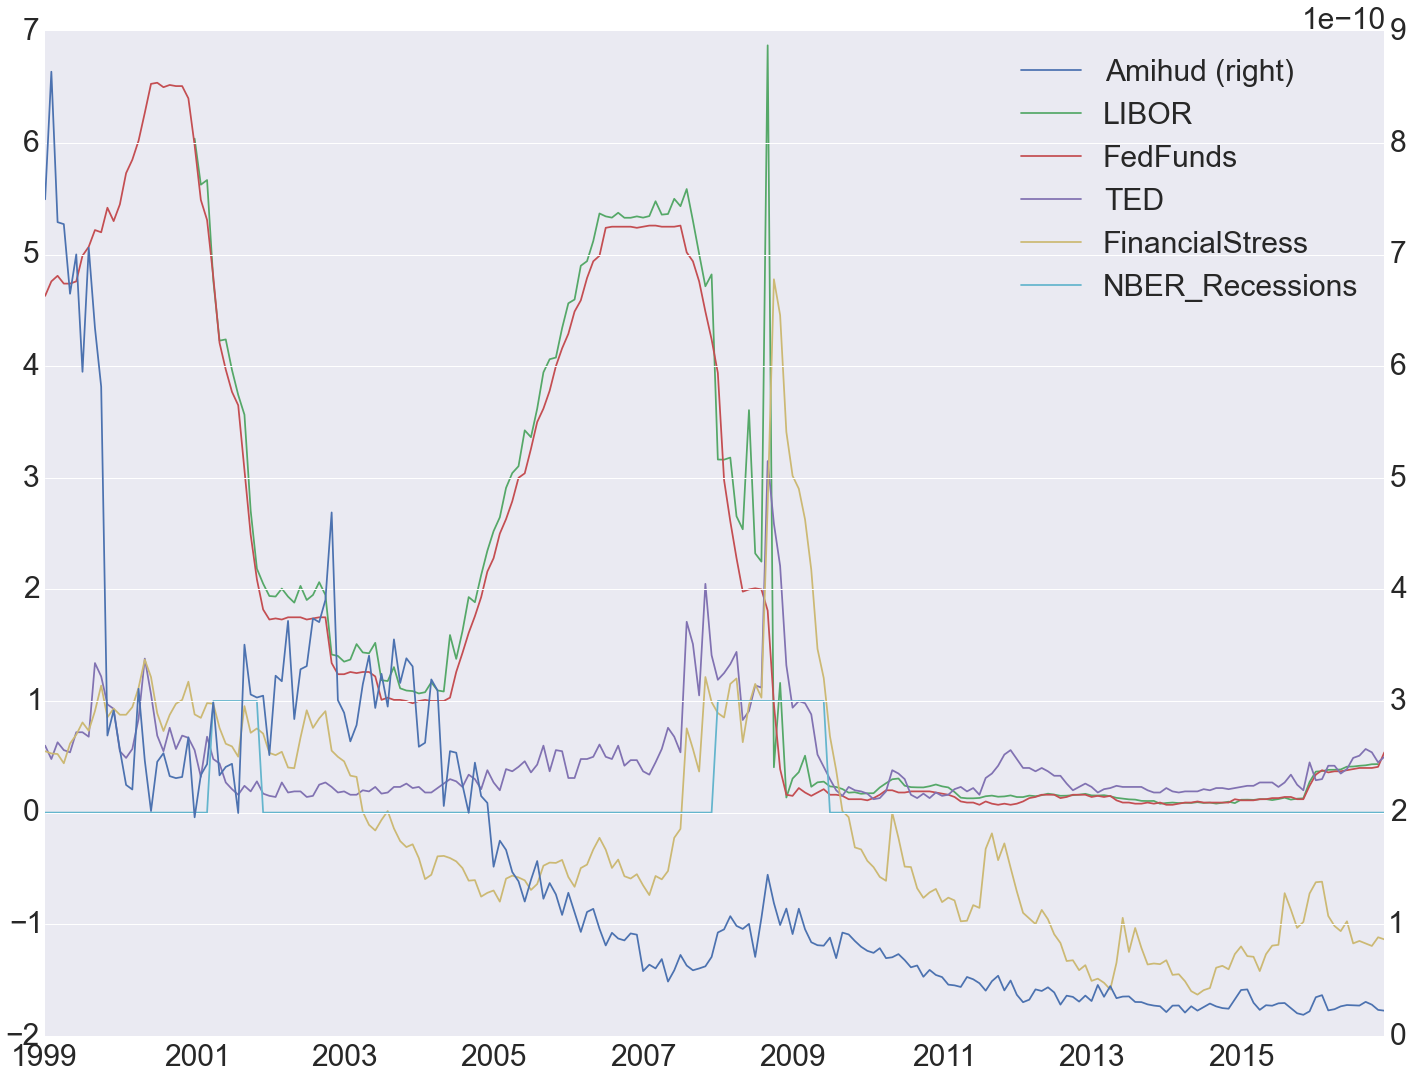

In [48]:
df.plot(secondary_y='Amihud')

In [49]:
df.to_csv('market_liquidity_factors.csv')

In [55]:
df=pd.read_csv('market_liquidity_factors.csv',index_col=0)

In [9]:
import pandas as pd
import statsmodels.formula.api as sm

In [57]:
df.dropna().head()

,Amihud,LIBOR,FedFunds,TED,FinancialStress,NBER_Recessions
2001-01-31,1.957619e-10,6.03875,5.98,0.56,0.880,0.0
2001-02-28,2.336865e-10,5.62625,5.49,0.32,0.849,0.0
2001-03-31,2.434383e-10,5.66813,5.31,0.68,0.981,0.0
2001-04-30,2.987170e-10,4.76875,4.80,0.48,0.976,1.0
2001-05-31,2.333881e-10,4.22875,4.21,0.44,0.759,1.0


In [67]:
data=df.dropna()
data['Alpha']=1
col=['LIBOR', 'TED', 'FinancialStress','NBER_Recessions','Alpha']
res=sm.OLS(data.Amihud,data[col]).fit()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [68]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                 Amihud   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     56.46
Date:                Sat, 10 Jun 2017   Prob (F-statistic):           4.07e-31
Time:                        16:42:50   Log-Likelihood:                 4188.7
No. Observations:                 191   AIC:                            -8367.
Df Residuals:                     186   BIC:                            -8351.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
LIBOR            1.772e-11   3.05e-12     

/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


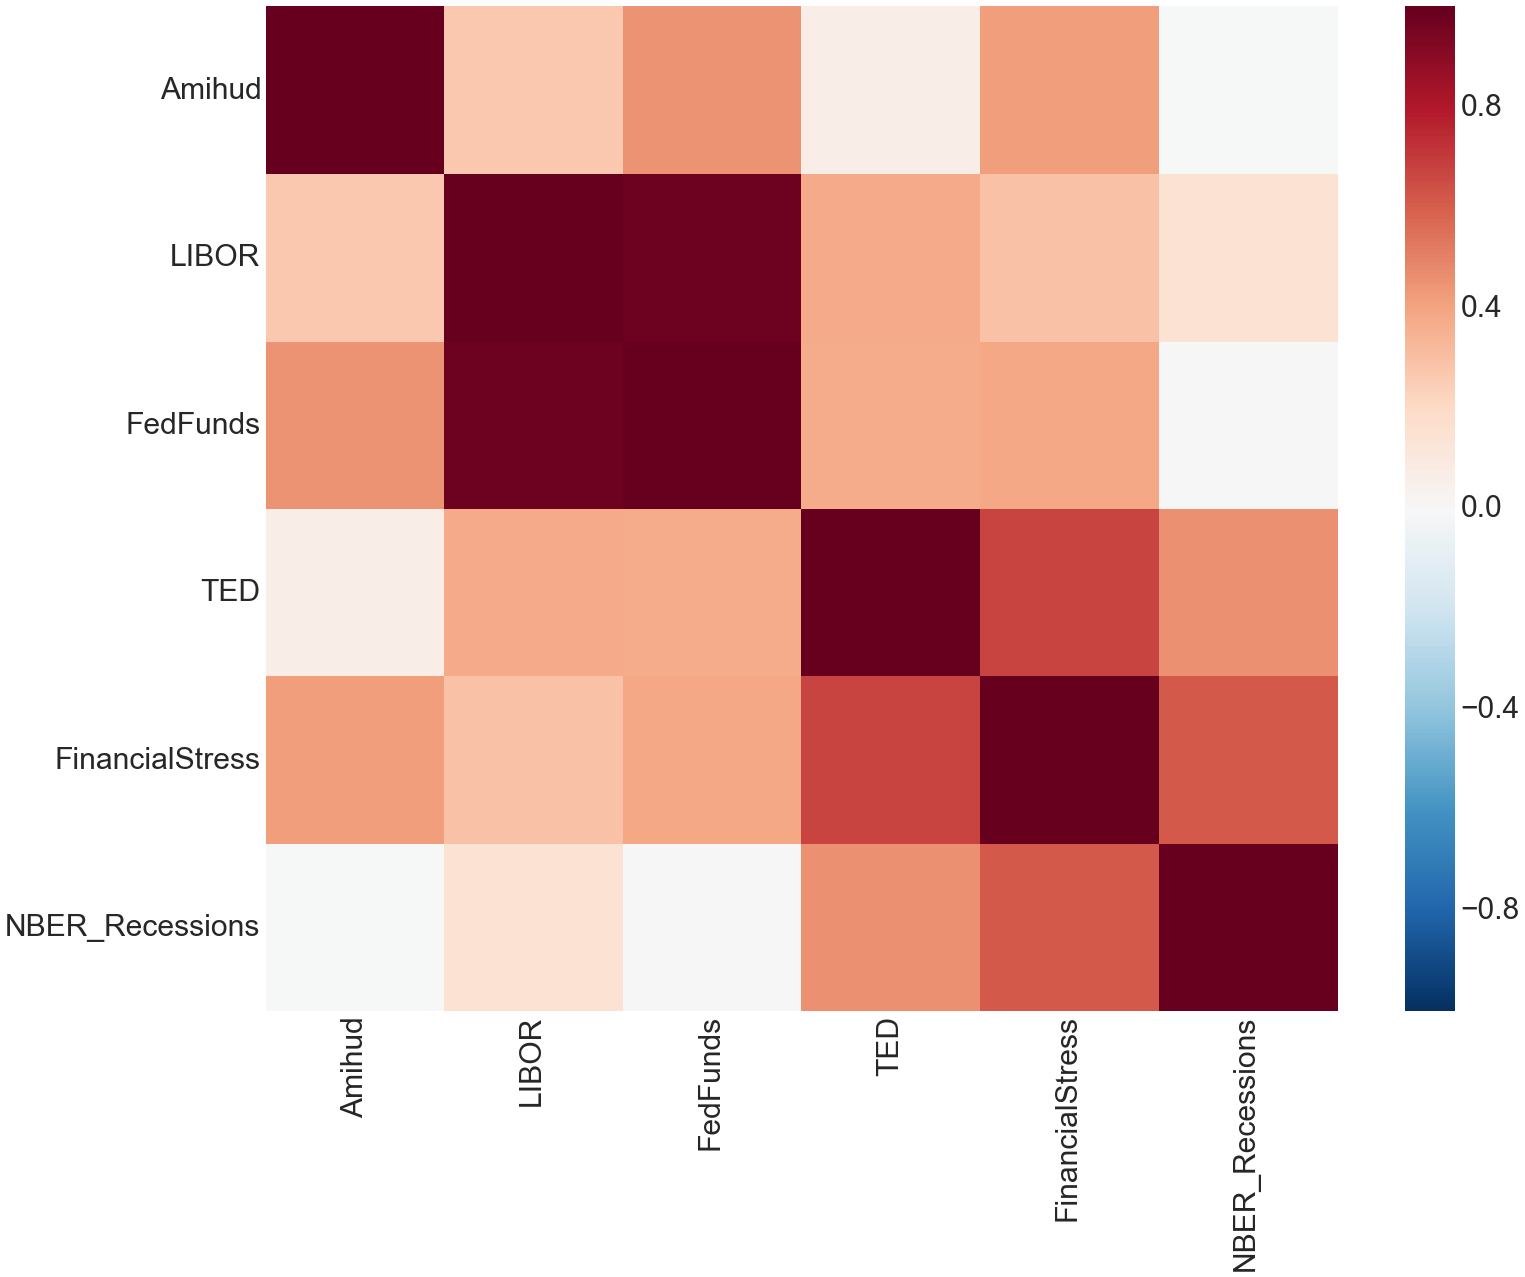

In [66]:
sns.heatmap(df.corr())